In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.get_mfccs(dataset,
                  blocksize=blocksize, 
                  overlap=overlap,
                  n_mels=128,
                  power_melgram=2.0,
                  decibel_gram=True
                 )

Epoch 1/1
2/2 [==============================] - 0s 39ms/step - loss: 1.3365


In [11]:
mfcc = pd.concat(df['mfcc'].values, keys=list(range(len(df))))

In [12]:
print(mfcc.shape)
quant = ps.quantize_mfccs(mfcc)

(1111104, 13)
Init 1/3 with method: k-means++
Inertia for init 1/3: 367060.839385
Init 2/3 with method: k-means++
Inertia for init 2/3: 366683.679510
Init 3/3 with method: k-means++
Inertia for init 3/3: 367009.537073
Minibatch iteration 1/2800: mean batch inertia: 3.100848, ewa inertia: 3.100848 
Minibatch iteration 2/2800: mean batch inertia: 3.063231, ewa inertia: 3.098075 
Minibatch iteration 3/2800: mean batch inertia: 3.043523, ewa inertia: 3.094053 
Minibatch iteration 4/2800: mean batch inertia: 3.054557, ewa inertia: 3.091141 
Minibatch iteration 5/2800: mean batch inertia: 3.033295, ewa inertia: 3.086876 
Minibatch iteration 6/2800: mean batch inertia: 3.045605, ewa inertia: 3.083833 
Minibatch iteration 7/2800: mean batch inertia: 3.038648, ewa inertia: 3.080502 
Minibatch iteration 8/2800: mean batch inertia: 3.058549, ewa inertia: 3.078883 
Minibatch iteration 9/2800: mean batch inertia: 3.012279, ewa inertia: 3.073972 
Minibatch iteration 10/2800: mean batch inertia: 3.02

Minibatch iteration 99/2800: mean batch inertia: 2.997672, ewa inertia: 2.974163 
Minibatch iteration 100/2800: mean batch inertia: 2.975562, ewa inertia: 2.974266 
Minibatch iteration 101/2800: mean batch inertia: 2.963701, ewa inertia: 2.973487 
Minibatch iteration 102/2800: mean batch inertia: 2.948542, ewa inertia: 2.971648 
Minibatch iteration 103/2800: mean batch inertia: 2.957286, ewa inertia: 2.970589 
Minibatch iteration 104/2800: mean batch inertia: 2.981890, ewa inertia: 2.971422 
Minibatch iteration 105/2800: mean batch inertia: 2.971987, ewa inertia: 2.971464 
Minibatch iteration 106/2800: mean batch inertia: 2.960520, ewa inertia: 2.970657 
Minibatch iteration 107/2800: mean batch inertia: 2.974953, ewa inertia: 2.970974 
Minibatch iteration 108/2800: mean batch inertia: 2.968944, ewa inertia: 2.970824 
Minibatch iteration 109/2800: mean batch inertia: 2.971189, ewa inertia: 2.970851 
Minibatch iteration 110/2800: mean batch inertia: 2.967475, ewa inertia: 2.970602 
Minib

In [13]:
X = pd.DataFrame(quant)
y_h = pd.Series(dataset['h_target'])
y_l = pd.Series(dataset['target'])

In [14]:
df = pd.DataFrame(X)
df['target'] = y_l
df['fold']=None

In [15]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
i = 1
folds = [None]*len(X)
for train_index, test_index in skf.split(X, np.zeros(len(X))):
    print(test_index)
    for idx in test_index:
        folds[idx] = i
    i += 1
df['fold']=folds

[  23   29   30   32   44   45   49   56   59   63   65   67   69   70
   73   76   78   99  100  109  111  115  120  123  124  128  135  162
  163  168  173  175  185  188  194  196  203  210  211  212  218  220
  231  233  237  239  247  251  254  256  261  266  270  275  281  289
  297  298  300  303  305  306  307  316  322  324  331  342  344  350
  351  352  353  354  361  366  367  368  374  382  383  393  394  411
  414  416  422  427  429  432  433  438  450  453  462  464  471  478
  479  480  482  485  494  495  507  514  519  526  527  529  530  534
  535  538  543  544  552  554  555  570  572  579  581  582  583  584
  585  591  599  602  607  610  611  613  617  618  620  628  630  637
  651  654  670  674  678  679  693  701  712  720  730  743  744  746
  755  757  759  764  771  780  782  785  787  788  792  802  807  808
  824  829  832  834  855  857  862  874  879  886  887  888  889  905
  906  907  909  916  930  937  938  944  949  964  965  973  974  978
  987 

In [16]:
df.head()

label,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,target,fold
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,3
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,19,4


In [17]:
X_train = df[df.fold > 1].drop(['fold', 'target'], axis=1)
X_test = df[df.fold == 1].drop(['fold', 'target'], axis=1)
y_train = df[df.fold > 1]['target']
y_test = df[df.fold == 1]['target']

In [18]:
X_train.shape

(1600, 2048)

In [19]:
y_train.shape

(1600,)

# Deep Net
Separate into classes

In [20]:
from sklearn.svm import SVC

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
  max_iter=1000, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

0.355
Confusion matrix, without normalization
[[4 0 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 5]]


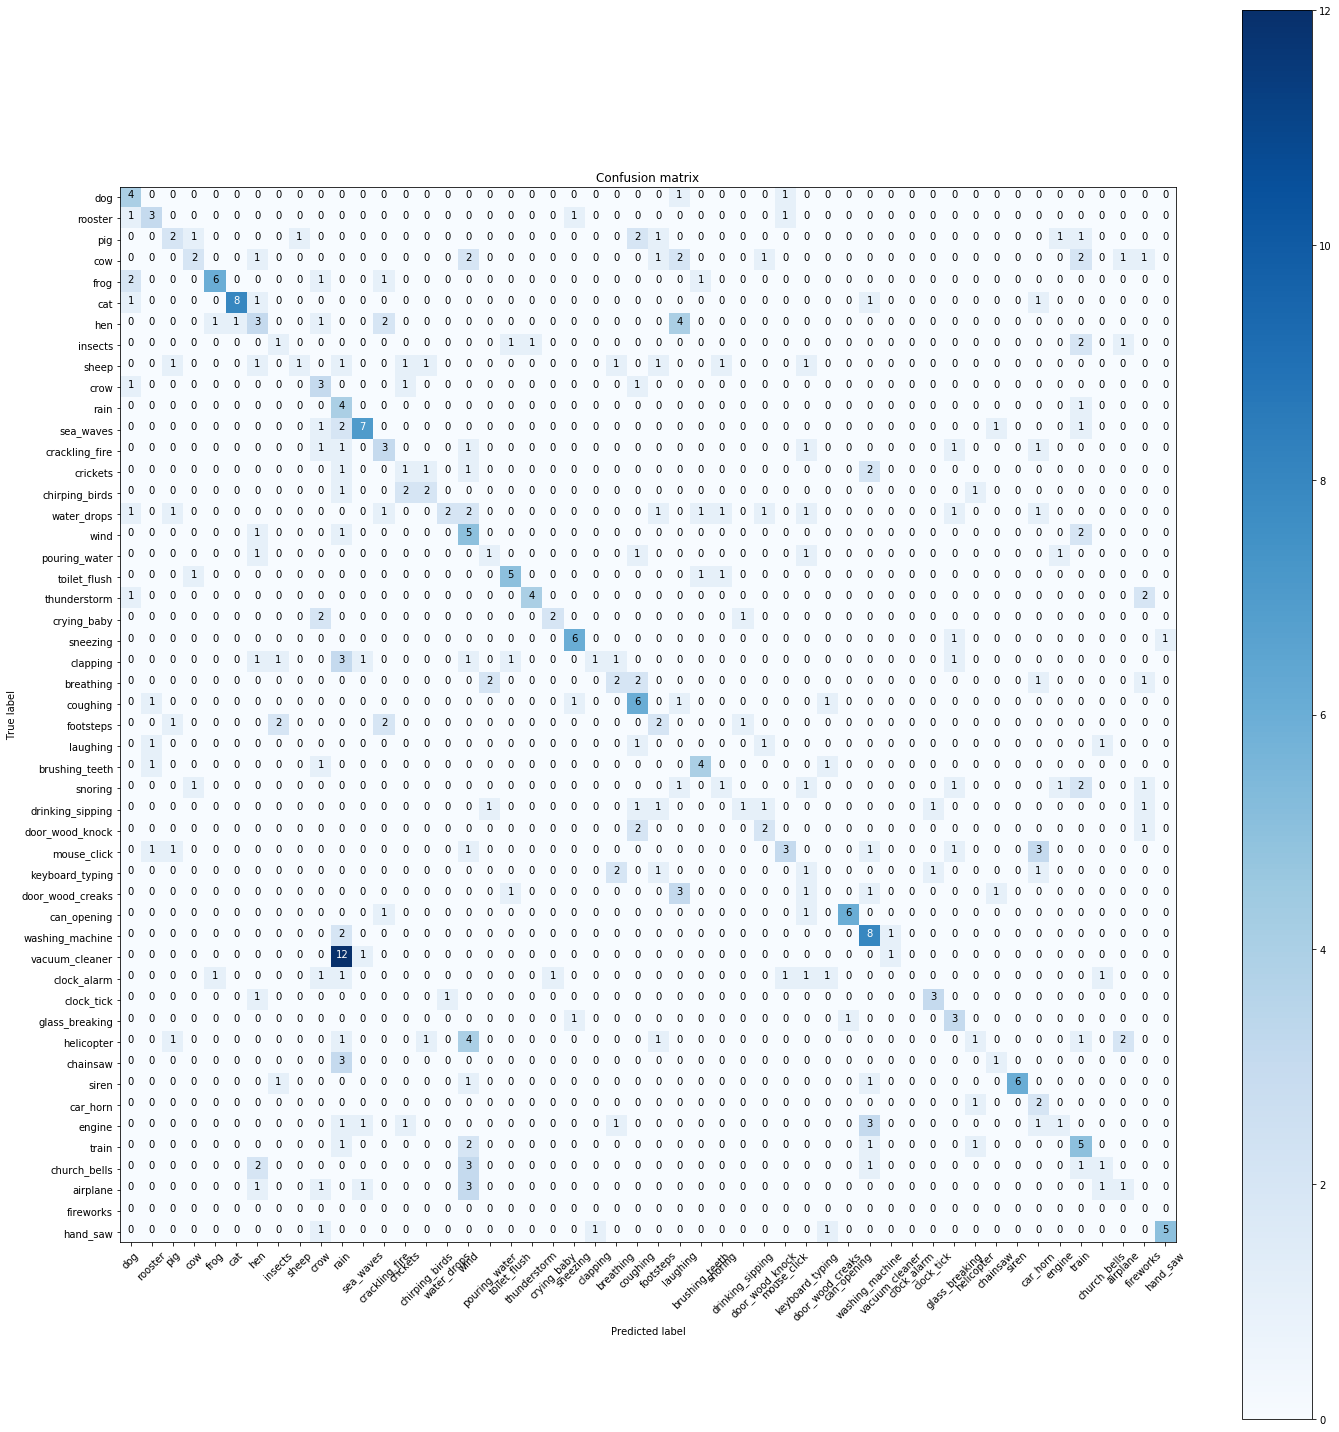

In [21]:
pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [22]:
y_test = y_test.reset_index(drop=True)

In [23]:
X_test = X_test.reset_index(drop=True)

In [24]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,len(y_test)):
    s_time = time.time()
    x_file = X_test[X_test.index == data_iloc]
    
    y_file = y_test[data_iloc]
    
    pred = clf.predict(x_file)
    predictions.append(pred)
    
    full_targets.append(y_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.571852445602417
	File Time: 0.4445667266845703
	File Time: 0.46165919303894043
	File Time: 0.5786929130554199
	File Time: 0.6207473278045654
	File Time: 0.5954535007476807
	File Time: 0.5915234088897705
	File Time: 0.6300971508026123
	File Time: 0.612703800201416
	File Time: 0.7841794490814209
	File Time: 0.42287349700927734
	File Time: 0.41625285148620605
	File Time: 0.4351654052734375
	File Time: 0.5645744800567627
	File Time: 0.5134682655334473
	File Time: 0.5048732757568359
	File Time: 0.44684576988220215
	File Time: 0.4441075325012207
	File Time: 0.7248339653015137
	File Time: 0.6405234336853027
	File Time: 0.673699140548706
	File Time: 0.5469615459442139
	File Time: 0.48096251487731934
	File Time: 0.6734676361083984
	File Time: 0.6341855525970459
	File Time: 0.5660836696624756
	File Time: 0.8810458183288574
	File Time: 0.5631849765777588
	File Time: 0.5150609016418457
	File Time: 0.46596384048461914
	File Time: 0.4886033535003662
	File Time: 0.4788956642150879
	File

	File Time: 0.5894386768341064
	File Time: 0.5269327163696289
	File Time: 0.47609615325927734
	File Time: 0.4618995189666748
	File Time: 0.4633502960205078
	File Time: 0.5571575164794922
	File Time: 0.5241336822509766
	File Time: 0.8404626846313477
	File Time: 0.5779190063476562
	File Time: 0.6012876033782959
	File Time: 0.6576991081237793
	File Time: 0.5967535972595215
	File Time: 0.6500778198242188
	File Time: 0.7118434906005859
	File Time: 0.6239645481109619
	File Time: 0.48382568359375
	File Time: 0.6904487609863281
	File Time: 0.5215613842010498
	File Time: 0.5394284725189209
	File Time: 0.6350870132446289
	File Time: 0.5943491458892822
	File Time: 0.6529464721679688
	File Time: 0.6161255836486816
	File Time: 0.548846960067749
	File Time: 0.5668132305145264
	File Time: 0.8611571788787842
	File Time: 0.6503539085388184
	File Time: 0.4886131286621094
	File Time: 0.45426487922668457
	File Time: 0.448610782623291
	File Time: 0.4590799808502197
	File Time: 0.470672607421875
	File Time:

0.355
0.3906581488686751
Confusion matrix, without normalization
[[4 0 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 5]]


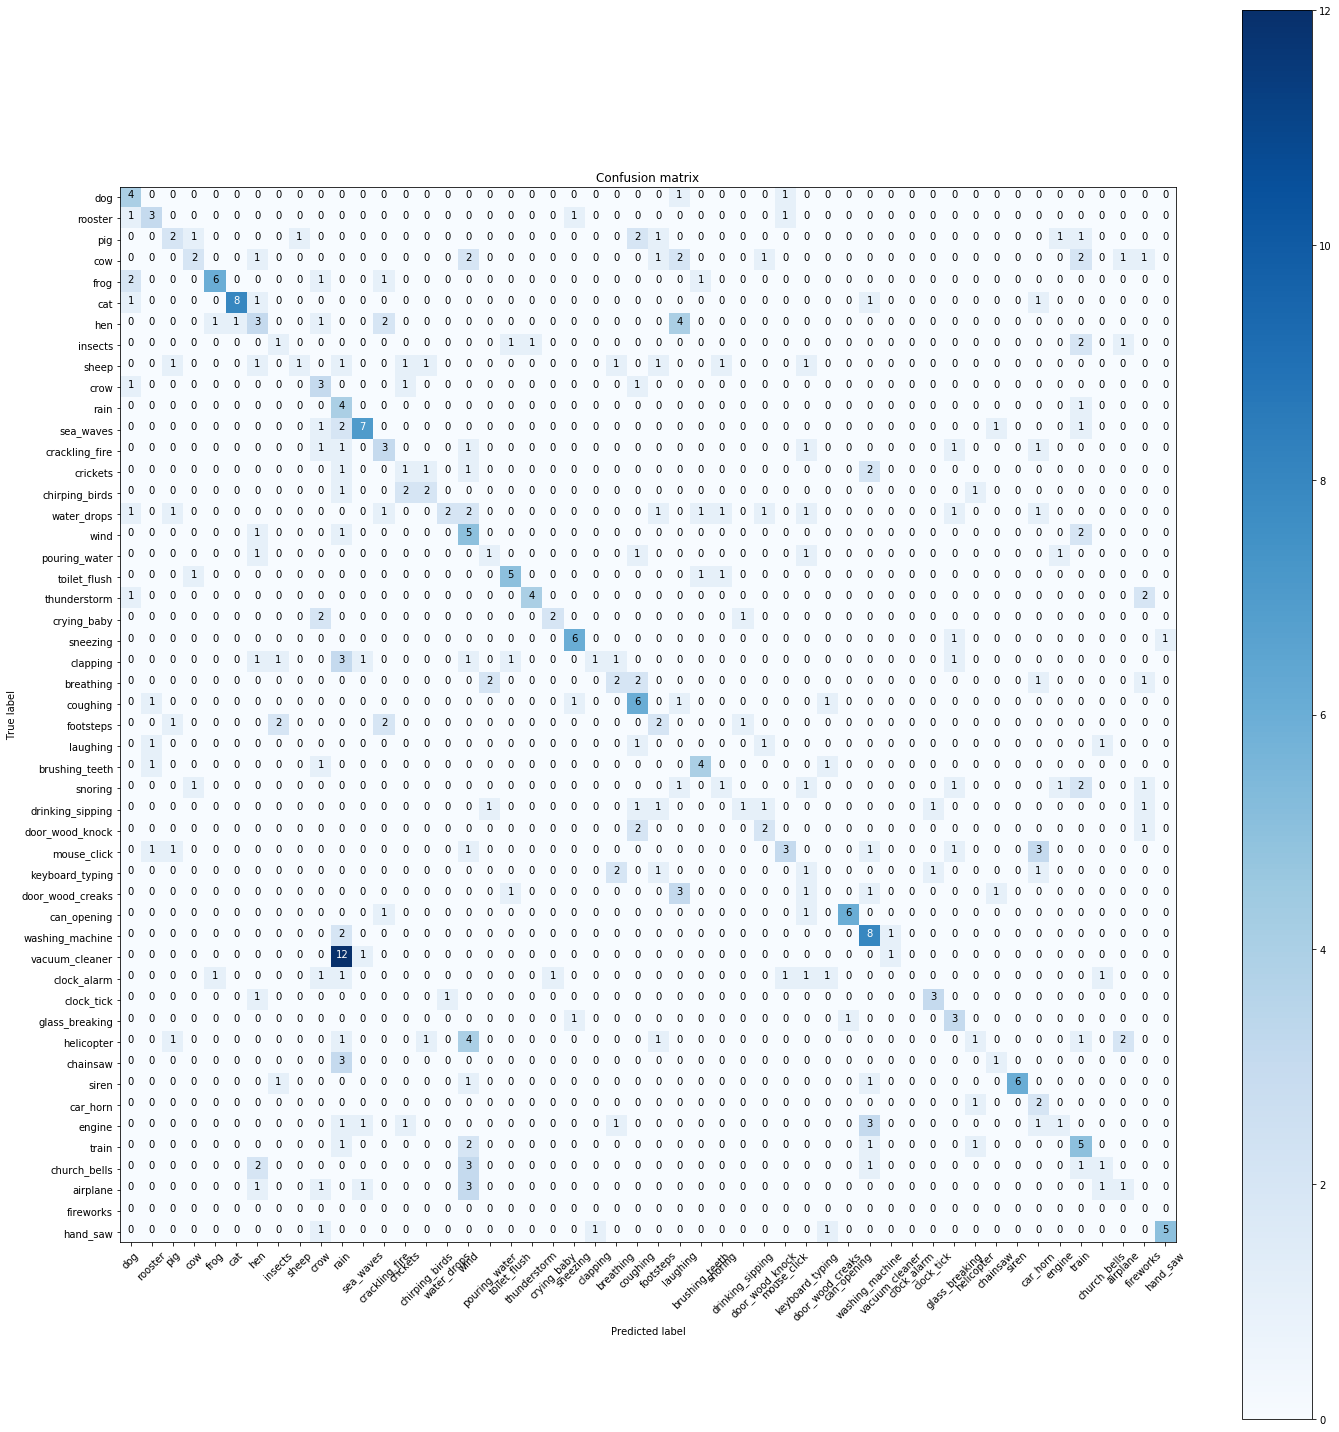

In [25]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [26]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [27]:
clf.fit(X_train, y_train)

In [28]:
pd.DataFrame(scores)

In [29]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(X_test)):
        x_file = X_test[X_test.index == data_iloc]
    
        y_file = y_test[data_iloc]
        
        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [30]:
%%time
preds = query_dataset('dog')

CPU times: user 3min 21s, sys: 2.44 s, total: 3min 24s
Wall time: 3min 23s


In [31]:
preds.head()

,ds_id,file,prediction,prob
0,212,1-43807-D-47.wav,[0],0.315261
1,277,1-56233-A-9.wav,[0],0.257126
2,97,1-20545-A-28.wav,[0],0.250978
3,317,1-65483-A-13.wav,[0],0.215090
4,318,1-67033-A-37.wav,[0],0.213936


In [32]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [33]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['airplane', 'crow', 'snoring', 'crickets', 'clock_alarm', 'toilet_flush', 'mouse_click', 'sneezing', 'airplane', 'can_opening']



0.0

In [34]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 3min 11s, sys: 1.41 s, total: 3min 13s
Wall time: 3min 11s
dog
['airplane', 'crow', 'snoring', 'crickets', 'clock_alarm', 'toilet_flush', 'mouse_click', 'sneezing', 'airplane', 'can_opening']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.84 ms
dog
0.0

CPU times: user 3min 8s, sys: 1.52 s, total: 3min 10s
Wall time: 3min 8s
rooster
['breathing', 'siren', 'crickets', 'hand_saw', 'dog', 'insects', 'hen', 'crow', 'washing_machine', 'hand_saw']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.32 ms
rooster
0.0

CPU times: user 3min 26s, sys: 1.7 s, total: 3min 28s
Wall time: 3min 27s
pig
['clock_tick', 'thunderstorm', 'cat', 'clock_tick', 'thunderstorm', 'fireworks', 'crickets', 'pouring_water', 'crying_baby']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.04 ms
pig
0.1

CPU times: user 3min 23s, sys: 2.11 s, total: 3min 25s
Wall time: 3min 24s
cow
['frog', 'car_horn', 'rooster', 'door_wood_knock', 'coughing', 'insects', 'wind', 'clapping'

CPU times: user 3min 24s, sys: 1.71 s, total: 3min 26s
Wall time: 3min 25s
door_wood_knock
['vacuum_cleaner', 'train', 'frog', 'coughing', 'engine', 'toilet_flush', 'helicopter', 'pig', 'water_drops', 'airplane']

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 6.39 ms
door_wood_knock
0.0

CPU times: user 3min 12s, sys: 1.49 s, total: 3min 14s
Wall time: 3min 12s
mouse_click
['crackling_fire', 'snoring', 'pouring_water', 'washing_machine', 'sheep', 'train', 'clapping', 'sea_waves', 'washing_machine']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.71 ms
mouse_click
0.1

CPU times: user 3min 19s, sys: 1.73 s, total: 3min 21s
Wall time: 3min 20s
keyboard_typing
['pouring_water', 'helicopter', 'church_bells', 'chirping_birds', 'can_opening', 'crackling_fire', 'toilet_flush', 'vacuum_cleaner', 'dog', 'sheep']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.27 ms
keyboard_typing
0.0

CPU times: user 3min 19s, sys: 2.24 s, total: 3min 21s
Wall time: 3min 20s
doo

0.024000000000000004